# data mining lab1

> Реализация линейной рециркуляционной сети как модели автодекодера для задачи понижения размерности данных.

### tasks

1. Реализовать модель линейной рециркуляционной сети.
2. Реализовать модель линейной рециркуляционной сети с адаптивным шагом обучения.
3. Реализовать модель линейной рециркуляционной сети с нормированными весами.
4. Реализовать модель линейной рециркуляционной сети с адаптивным шагом обучения с нормированными весами.

> Рециркуляционные нейронные сети применяются для сжатия (прямое преобразование) и восстановления исходной (обратное преобразование) информации.

### solution

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [160]:
import math

def get_data(filename='doge.png', n=8, m=8):
    data = mpimg.imread(f'data/{filename}')
    data = data[:, :, :3]
    
    img_size = data.shape[0] * data.shape[1]
    rect_size = n * m # L
    
    num_rects = math.ceil(img_size / rect_size)
    num_features = rect_size * data.shape[2]

    output = np.resize(data.flatten(), new_shape=(num_rects, num_features))
    return data, output * 2 - 1 # normilize

def clip_data(data):
    return (np.clip(data, -1, 1) + 1) / 2

In [161]:
def get_initial_weights(input_size, output_size):
    return np.random.uniform(-1, 1, size=(input_size, output_size))

# Z(P, N, L)
def get_compression_factor(P, N, L):
    return (N * L) / ((N + L) * P + 2)

def transform(X, w1, w2, out_shape):
    Y = clip_data(X.dot(w1).dot(w2))
    return np.resize(Y, new_shape=out_shape)

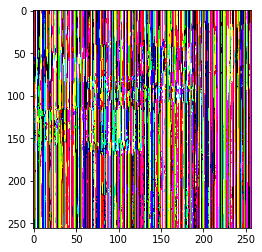

In [162]:
P = 160
original, X = get_data()

L, N = X.shape

w1 = get_initial_weights(N, P)
w2 = get_initial_weights(P, N)

Y = transform(X, w1, w2, original.shape)
plt.imshow(Y)

In [187]:
def get_alpha(alpha, X, Y):
    if alpha:
        return alpha, alpha
    alpha_y = 1 / np.sum(Y.dot(Y.T))
    alpha_x = 1 / np.sum(X.dot(X.T))
    return alpha_x, alpha_y

def normilize_weight(w):
    for j in range(w.shape[1]):
        norm = np.linalg.norm(w[:,j])
        w[:,j] = w[:,j] / norm
    return w

def train_model(X, p, max_err=1000, alpha=None):
    L, n = X.shape
    Z = get_compression_factor(p, n, L)
    err = max_err + 1
    
    w1 = get_initial_weights(n, p)
    w2 = get_initial_weights(p, n)
    
    iter_limit = int(10e5 / L)
    iterations_counter = 0
    for k in range(iter_limit):
        errors = np.zeros(L)
        for i in range(L):
            Xi = X[i].reshape((1, -1))
            Y = Xi.dot(w1).reshape((1, -1))
            Xr = Y.dot(w2)
            dX = Xr - Xi
            
            alpha_x, alpha_y = get_alpha(alpha, X, Y)
            w1 = w1 - alpha_x * Xi.T.dot(dX).dot(w2.T)
            w2 = w2 - alpha_y * Y.T.dot(dX)
            
            w1 = normilize_weight(w1)
            w2 = normilize_weight(w2)

            errors[i] = np.sum(dX ** 2)
            iterations_counter += 1

        err = np.sum(errors)
        if err <= max_err:
            break
            
    return w1, w2, iterations_counter, err, Z

In [164]:
w1, w2, iterations, err, Z = train_model(X, P, max_err=300)

Iterations:	6144
Compression F:	1.011
Error:		279.946


((192, 160), (160, 192))

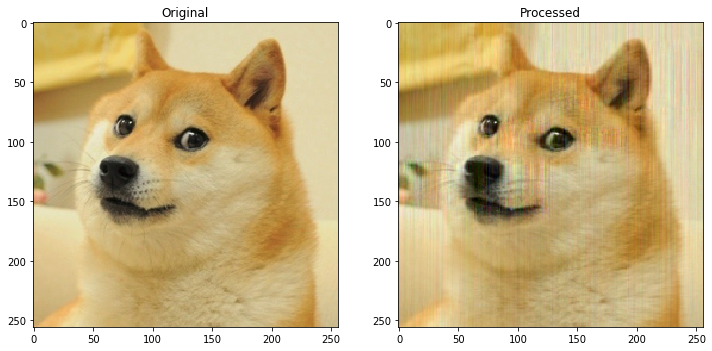

In [165]:
Y = transform(X, w1, w2, original.shape)

size = 12
fig, ax = plt.subplots(1, 2, figsize=(size, size))
ax[0].imshow(original)
ax[0].set_title('Original', fontsize=size)
ax[1].imshow(Y)
ax[1].set_title('Processed', fontsize=size)

print(f'Iterations:\t{iterations}\nCompression F:\t{Z:.3f}\nError:\t\t{err:.3f}')
w1.shape, w2.shape

In [188]:
def line_plot(x, y, xlabel, ylabel, title=''):
    plt.figure(figsize=(12, 8))
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### iterations count by Z-factor

In [189]:
ps = range(100, P, 8)
zs = []
iters = []
for p in ps:
    _, x = get_data()
    _, _, i, err, Z = train_model(x, p)
    zs.append(Z)
    iters.append(i)

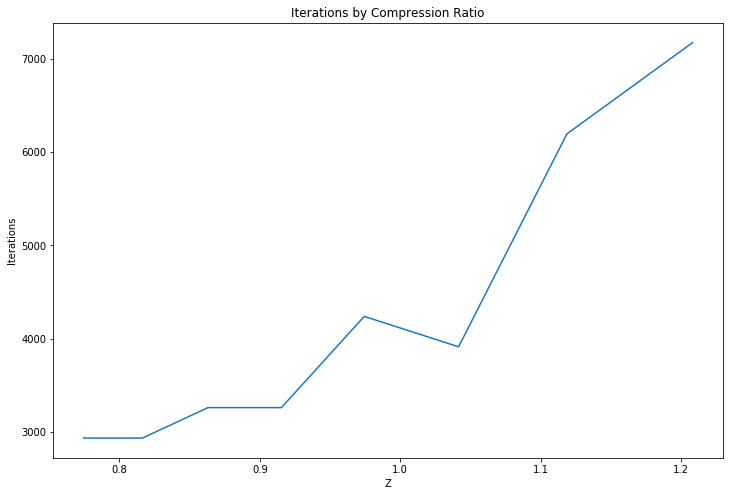

In [191]:
line_plot(zs, iters, 'Z', 'Iterations', 'Iterations by Compression Ratio')

### iterations count by max-error

In [204]:
errs = np.arange(1000, 2000, 100)
e_iters = []
for e in errs:
    _, x = get_data('test1.png')
    _, _, i, _, _ = train_model(x, P, max_err=e)
    e_iters.append(i)

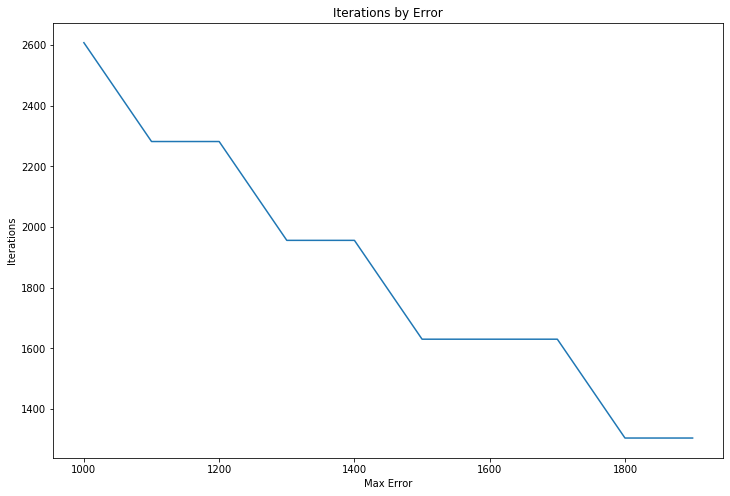

In [205]:
line_plot(errs, e_iters, 'Max Error', 'Iterations', 'Iterations by Error')

### iterations count by alpha

In [206]:
alphas = np.arange(0.0001, 0.0005, 0.00005)
a_iters = []
for a in alphas:
    _, x = get_data()
    _, _, i, _, _ = train_model(x, P, max_err=3000, alpha=a)
    a_iters.append(i)

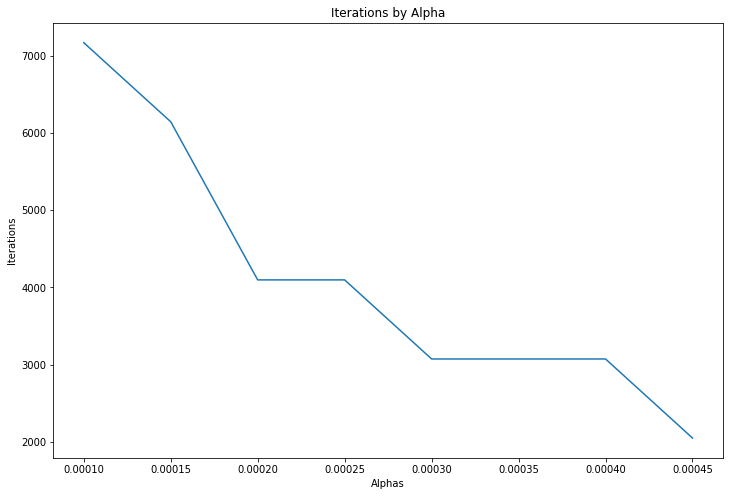

In [207]:
line_plot(alphas, a_iters, 'Alphas', 'Iterations', 'Iterations by Alpha')